# Advanced Lane Finding Project

The goals / steps of this project are the following:

    1) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    2) Apply a distortion correction to raw images.
    3) Use color transforms, gradients, etc., to create a thresholded binary image.
    4) Apply a perspective transform to rectify binary image ("birds-eye view").
    5) Detect lane pixels and fit to find the lane boundary.
    6) Determine the curvature of the lane and vehicle position with respect to center.
    7) Warp the detected lane boundaries back onto the original image.
    8) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Importing neccessary libraries and creating the Line class

In [3]:
import matplotlib.image as mpimg
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class camera_param():

    def __init__(self):
        mtx, dist = calibrate_camera()
        self.mtx = mtx
        self.dist = dist

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_fitted = deque(maxlen=3)
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = {}
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None


# Camera Calibration

For the camera calibration, I modified the example code provided in class. Essentially, the code does the following:

    1) Import the image
    2) Create a placeholder array to collect the corner points of the image
    3) Detect the image corner using cv2.findChessboardCorners and put it into the placeholder array
    4) Use cv2.calibrateCamera to correct each image
    5) Save the calibration information into a pickle file so that this calibration can be skipped on future runs

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def calibrate_camera():

    img = cv2.imread('camera_cal/calibration19.jpg')
    img_size = (img.shape[1], img.shape[0])

    try:
        cal_data = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
        mtx = cal_data["mtx"]
        dist = cal_data["dist"]
        # print('CAMERA CALIBRATION EXIST')


    except (OSError, IOError) as e:


        chess_size = [9,6]
        objp = np.zeros((chess_size[1]*chess_size[0],3), np.float32)
        objp[:,:2] = np.mgrid[0:chess_size[0], 0:chess_size[1]].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (chess_size[0],chess_size[1]), None)
            # print(fname)
            # print(ret)
            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

                # Draw and display the corners
                #cv2.drawChessboardCorners(img, (chess_size[0],chess_size[1]), corners, ret)
                #write_name = 'corners_found'+str(idx)+'.jpg'
                #cv2.imwrite(write_name, img)
                #cv2.imshow('img', img)
                #cv2.waitKey(500)

        #cv2.destroyAllWindows()

        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open("camera_cal/wide_dist_pickle.p", "wb" ) )




    # Test undistortion on an image





    dst = cv2.undistort(img, mtx, dist, None, mtx)

    ################################EXAMPLE PLOT ########################
    #cv2.imshow('img', dst)
    cv2.imwrite('calibration_wide/test_undist.jpg',dst)

    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    #Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()
    print('CAMERA CALIBRATION COMPLETE')
    ######################################################################
    return mtx,dist

def distort_correction(img,mtx,dist):

    image_corrected = cv2.undistort(img, mtx, dist, None, mtx)

    return image_corrected


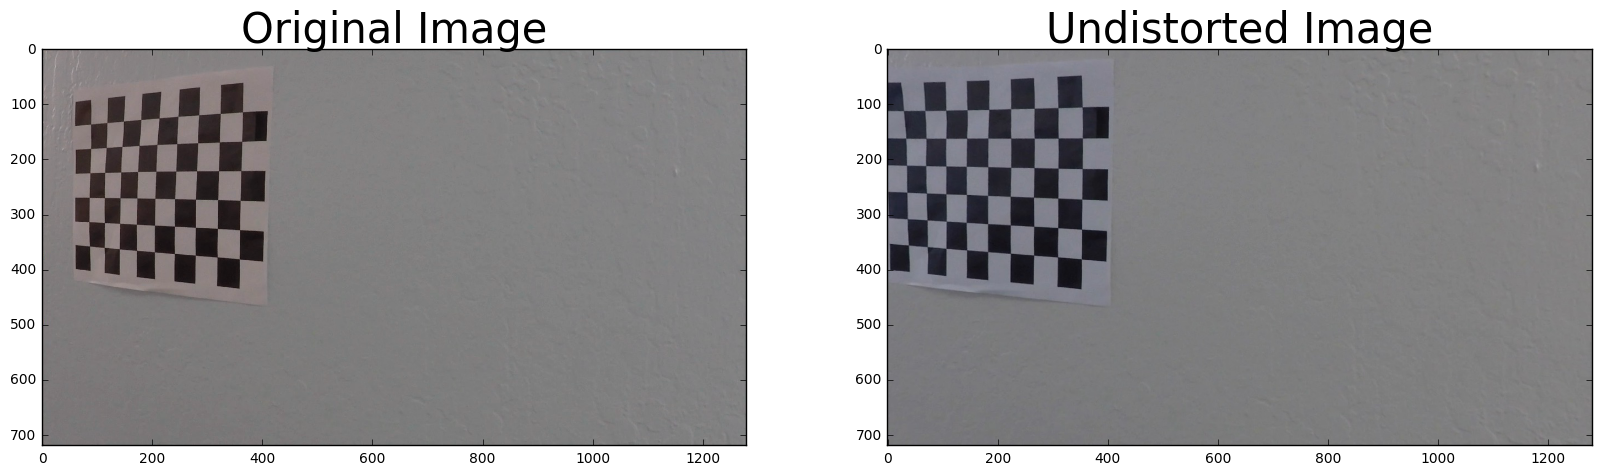

CAMERA CALIBRATION COMPLETE


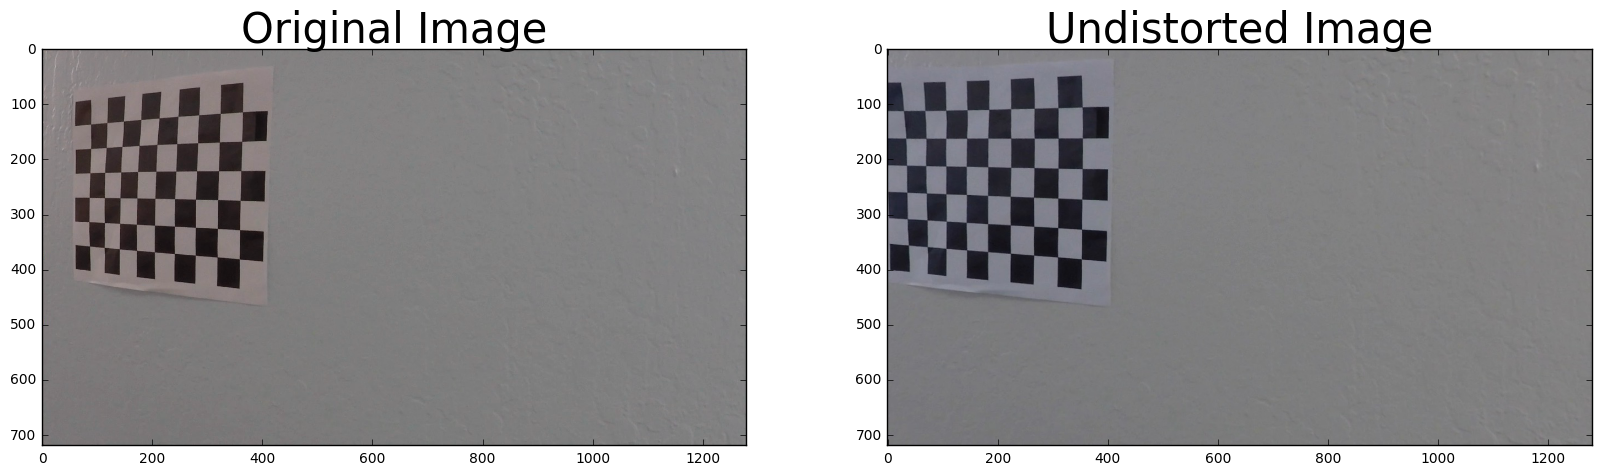

CAMERA CALIBRATION COMPLETE


In [5]:
camera = camera_param()
mtx, dist = calibrate_camera()

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one: 

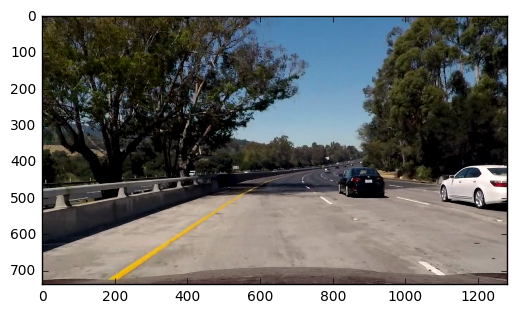

In [6]:
img = mpimg.imread('test_images/03.png', np.uint8)
image_corrected = distort_correction(img,mtx,dist)
plt.imshow(image_corrected)

# Color Gradient

I have tried various methods for the color gradient. For the final result, the best filter is to use a mixture of RGB, HLS, and HLV color space to extract information from the red, saturation, and value layer. With the saturation layer, I took the saturation layer and Sobel (x-direction) layer and combined all of the binary images into one array to generate one binary image. I have shown an example of my output below:

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ColorGradient(image):
    def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        thresh_min = thresh[0]
        thresh_max = thresh[1]
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        grad_binary = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Calculate directional gradient
        # Apply threshold
        return grad_binary

    def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # Create a binary image of ones where threshold is met, zeros otherwise
        mag_binary = np.zeros_like(gradmag)
        mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return mag_binary

    def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Calculate gradient direction
        # Apply threshold

        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction,
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        dir_binary = np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return dir_binary

    def combined_threshold(img):


        # Choose a Sobel kernel size
        ksize = 3 # Choose a larger odd number to smooth gradient measurements

        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 150))
        grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 150))
        mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(65, 120))
        dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

        return combined





    s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:, :, 2]
    v_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:, :, 2]
    r_channel =image[:, :, 0]

    v_thresh_min = 210
    v_thresh_max = 255
    v_binary = np.zeros_like(s_channel)
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1
    # plt.imshow(v_binary, cmap='gray')

    r_thresh_min = 210
    r_thresh_max = 255
    r_binary = np.zeros_like(s_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    # plt.imshow(r_binary, cmap='gray')


    s_thresh_min = 120
    s_thresh_max = 225
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    plt.imshow(s_binary, cmap='gray')

    s_threshold = abs_sobel_thresh(image, orient='x', sobel_kernel=15, thresh=(20, 150))

    plt.imshow(s_threshold,cmap='gray')

    combined_binary = np.zeros_like(s_threshold)
    combined_binary[(s_threshold == 1)| (r_binary == 1)| (v_binary == 1)] = 1
    plt.imshow(combined_binary, cmap='gray')
    return combined_binary


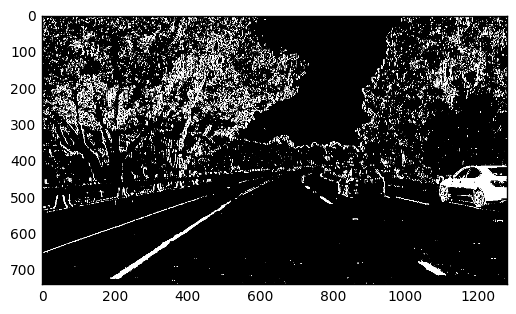

In [8]:
edge_detect = ColorGradient(image_corrected)
plt.imshow(edge_detect, cmap='gray')

# Perspective Transform

For this section my function takes a certain area of interests and transform the image as if the image is from the top down view.

In [9]:
import numpy as np
import cv2

def TransformPersective():


    left_bottom = [260, 675]
    left_top = [570, 470]

    right_bottom = [1050, 675]
    right_top = [720, 470]

    unwarped_top_left = [200, 0]
    unwarped_top_right = [1080, 0]

    unwarped_bottom_left = [200, 680]
    unwarped_bottom_right = [1080, 680]

    src = np.array([left_bottom,left_top,right_top,right_bottom], np.float32)
    dst = np.array([unwarped_bottom_left,unwarped_top_left,unwarped_top_right,unwarped_bottom_right], np.float32)


    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv


def unwarp_img(img,M):
    unwarped_img = cv2.warpPerspective(img*255, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

    return unwarped_img


This resulted in the following source and destination points:

|  Source  | Destination |
|----------|-------------|
|  260,675 |     200,680 |
|  570,470 |       200,0 |
| 1050,675 |    1080,680 |
|  720,470 |      1080,0 |


I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

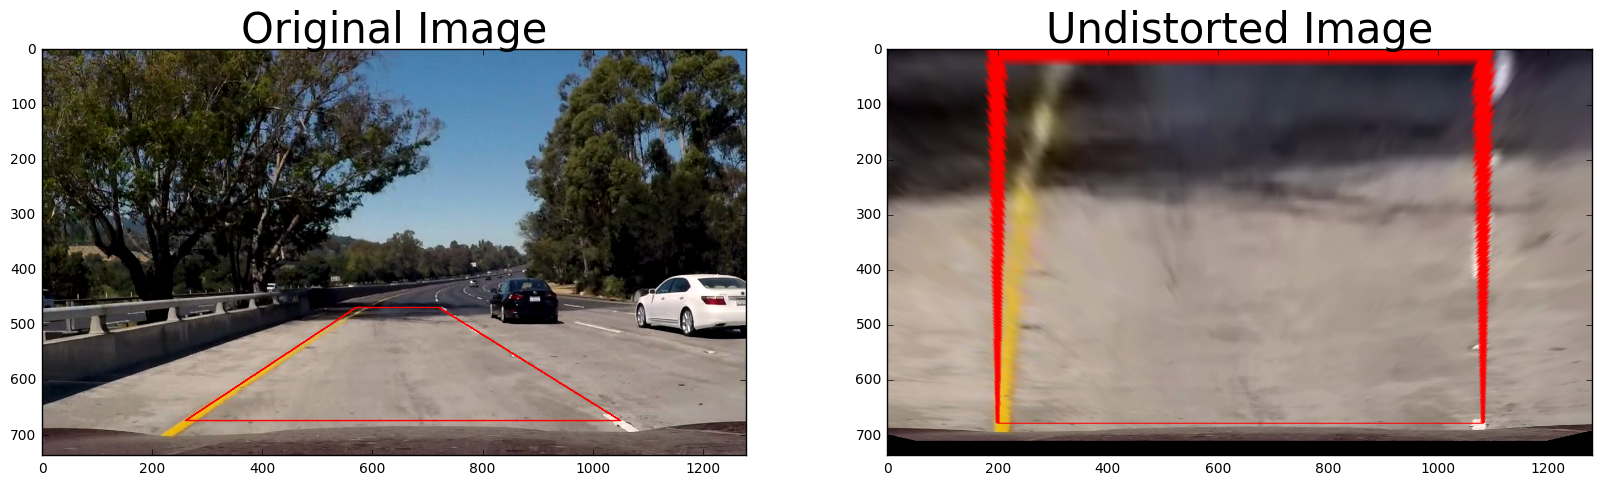

CAMERA CALIBRATION COMPLETE


In [10]:
    left_bottom = [260, 675]
    left_top = [570, 470]

    right_bottom = [1050, 675]
    right_top = [720, 470]

    unwarped_bottom_left = [200, 680]
    unwarped_top_left = [200, 0]

    unwarped_bottom_right = [1080, 680]
    unwarped_top_right = [1080, 0]


    src = np.array([left_bottom,left_top,right_top,right_bottom], np.float32)
    dst = np.array([unwarped_bottom_left,unwarped_top_left,unwarped_top_right,unwarped_bottom_right], np.float32)


    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img = mpimg.imread('test_images/03.png', np.uint8)
    image_lines = img
    image_lines = cv2.line(img, (src[0,0], src[0,1]), (src[1,0], src[1,1]), color=[255, 0, 0], thickness=2)
    image_lines = cv2.line(image_lines, (src[1,0], src[1,1]), (src[2,0], src[2,1]), color=[255, 0, 0], thickness=2)
    image_lines = cv2.line(image_lines, (src[2,0], src[2,1]), (src[3,0], src[3,1]), color=[255, 0, 0], thickness=2)
    image_lines = cv2.line(image_lines, (src[3,0], src[3,1]), (src[0,0], src[0,1]), color=[255, 0, 0], thickness=2)
    
    unwarped_img = cv2.warpPerspective(image_lines, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    #Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(unwarped_img)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()
    print('CAMERA CALIBRATION COMPLETE')
 


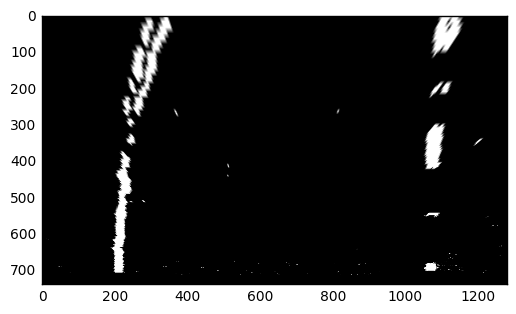

In [11]:
M, Minv = TransformPersective()
flat_image = unwarp_img(edge_detect,M)
plt.imshow(flat_image, cmap='gray')

# Line Detection

I used the sliding window search that is provided through class. It does the following:
    1) Slice the image into horizontal sections
    2) Calculate the histogram and find the peaks 
    3) Locate the peaks and slide the window throughout the image
    4) Copy all the pixel locations that are lanes within the sliding window

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def LineDetect(binary_warped,left,right):
    # binary_warped = np.floor(binary_warped / 255)

    if len(left.current_fit) == 0:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image

        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        # left_fit = np.polyfit(lefty, leftx, 2)
        # right_fit = np.polyfit(righty, rightx, 2)

    else:
    #############################################################################################
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!


        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left.current_fit['np.power(b, 2)'] * (nonzeroy ** 2) + left.current_fit['b'] * nonzeroy + left.current_fit['Intercept'] - margin)) & (
        nonzerox < (left.current_fit['np.power(b, 2)'] * (nonzeroy ** 2) + left.current_fit['b'] * nonzeroy + left.current_fit['Intercept'] + margin)))
        right_lane_inds = ((nonzerox > (right.current_fit['np.power(b, 2)'] * (nonzeroy ** 2) + right.current_fit['b'] * nonzeroy + right.current_fit['Intercept'] - margin)) & (
        nonzerox < (right.current_fit['np.power(b, 2)'] * (nonzeroy ** 2) + right.current_fit['b'] * nonzeroy + right.current_fit['Intercept'] + margin)))

        # print(right_lane_inds)
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # # Fit a second order polynomial to each
        # left_fit = np.polyfit(lefty, leftx, 2)
        # right_fit = np.polyfit(righty, rightx, 2)
        # # # Generate x and y values for plotting
        # ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        # left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        # right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]




    return leftx, lefty, rightx, righty



Next, I fit the pixels using the statsmodel toolbox with the following method

    1) Fit the pixels using the robust linear model which filters out outliers
    2) Take the previous two fits as well to smooth out the features
    3) Fit the line through the height of the image with a pixel scaling factor to convert pixel to distance
    4) Calculate the curvature from the equation shown in class
    5) Export all the results through the Line() class


In [13]:
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.robust.robust_linear_model import RLM
def LineFit(img,x_loc,y_loc,line):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension




    data = {"a": x_loc, "b":y_loc}
    result_lin = RLM.from_formula(formula='a ~ np.power(b, 2) + b ', data=data).fit()

    #result_lin = sm.ols(formula='a ~ np.power(b, 2) + b ', data=data).fit()

    # Fit a second order polynomial to pixel positions in each fake lane line
    # fit_func = np.polyfit(y_loc, x_loc, 2)
    line.recent_fitted.append(result_lin.params)


    # y_loc_fit =  np.insert(ploty, 0, img.shape[0])
    # y_loc_fit = np.append(y_loc_fit, 0)
    y_loc_fit = ploty

    Avar = 0
    Bvar = 0
    Cvar = 0
    total = 0
    for fit_func in line.recent_fitted:
        Avar = Avar + fit_func['np.power(b, 2)']
        Bvar = Bvar + fit_func['b']
        Cvar = Cvar + fit_func['Intercept']
        total += 1

    fitx = Avar/total*y_loc_fit**2 + Bvar/total*y_loc_fit + Cvar/total

    temp_line = {}

    temp_line['np.power(b, 2)'] = Avar
    temp_line['b'] = Bvar
    temp_line['Intercept'] = Cvar

    line.current_fit = result_lin.params

    y_eval = np.max(ploty)
    fit_cr = np.polyfit(ploty * ym_per_pix, fitx * xm_per_pix, 2)
    curverad = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])




    return fitx, y_loc_fit,curverad


Next, the average curvature is calculated which is represented of the curvature of the center of the lane. The offset of the car is calculated by determining the average location of the last bottom pixel. This is compared to the center of the image (assuming the camera is center). 

Center radius of curvature: 866 m
Left of center by 0.11 m


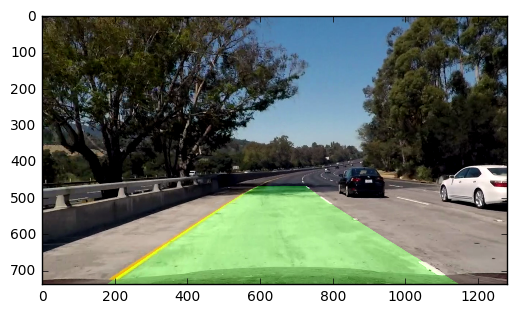

In [14]:

left = Line()
right = Line()

img = mpimg.imread('test_images/03.png', np.uint8)


img_size = (img.shape[1], img.shape[0])

image_corrected = distort_correction(img,mtx,dist)

edge_detect = ColorGradient(image_corrected)

flat_image = unwarp_img(edge_detect,M)



left_x, left_y, right_x, right_y = LineDetect(flat_image, left, right)

left_fit_x, left_fit_y, left_curverad = LineFit(flat_image,left_x,left_y,left)
right_fit_x, right_fit_y, right_curverad = LineFit(flat_image,right_x,right_y,right)





# plt.imshow(flat_image, cmap='gray')
# plt.plot(left_fit_x,left_fit_y)
# plt.plot(right_fit_x,right_fit_y)
# plt.show()


# Create an image to draw the lines on
warp_zero = np.zeros_like(flat_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fit_x, left_fit_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, right_fit_y])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
# Combine the result with the original image
# newwarp = np.floor(newwarp/255).astype('float32')
nonzero_warp = np.nonzero(newwarp[-1,:,1])


xm_per_pix = 3.7 / 700
center_offset = (((nonzero_warp[0][0] + nonzero_warp[0][-1])/2) - np.floor(img.shape[1]/2)) * xm_per_pix
curvature = (left_curverad+right_curverad)/2
print( "Center radius of curvature: {} m".format(int(curvature)))

if center_offset > 0:
    print("Left of center by {:.2f} m".format(center_offset))
else:
    print("Right of center by {:.2f} m".format(center_offset))


result = cv2.addWeighted(image_corrected, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

I feed everything to the moviepy pipeline and calculate everything previously explained to each frame of the video.

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:59<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 



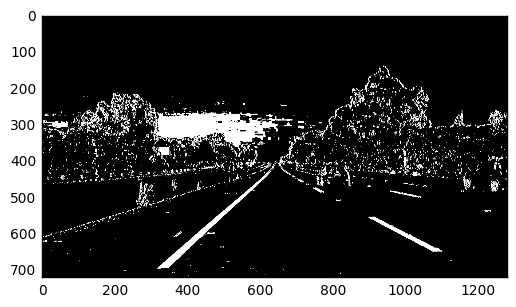

In [15]:
from moviepy.editor import VideoFileClip
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    mtx = camera.mtx
    dist = camera.dist
    M, Minv = TransformPersective()

    image_corrected = distort_correction(img, mtx, dist)
    img_size = (img.shape[1], img.shape[0])
    edge_detect = ColorGradient(image_corrected)

    flat_image = unwarp_img(edge_detect, M)

    left_x, left_y, right_x, right_y = LineDetect(flat_image, left, right)

    left_fit_x, left_fit_y, left_curverad = LineFit(flat_image, left_x, left_y, left)
    right_fit_x, right_fit_y, right_curverad = LineFit(flat_image, right_x, right_y, right)

    xm_per_pix = 3.7 / 700
    center_offset = (((right_fit_x[-1] + left_fit_x[-1]) / 2) - np.floor(img.shape[1] / 2)) * xm_per_pix
    curvature = (left_curverad + right_curverad) / 2

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(flat_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, left_fit_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, right_fit_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    # newwarp = np.floor(newwarp/255).astype('float32')


    final_image = cv2.addWeighted(image_corrected, 1, newwarp, 0.3, 0)


    font = cv2.FONT_HERSHEY_PLAIN
    text = "Center radius of curvature: {} m".format(int(curvature))
    cv2.putText(final_image, text, (100, 100), font, 1, (255, 255, 255), 2)

    text = "Left of center by {:.2f} m".format(center_offset)
    cv2.putText(final_image, text, (100, 150), font, 1, (255, 255, 255), 2)


    return final_image

left = Line()
right = Line()
camera.mtx = mtx
camera.dist = dist

white_output = 'output1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


# Discussion

The hardest time I had was to fit the lines. At first, I had trouble getting the color gradient to work. I tried multiple methods but resorted to the original method that was suggested in class. Also, the sliding window technique was not as robust as I wanted it to be. I tried to make the convolution technique to work but had no luck. Currently, the robust linear fit is not as robust as it could be. The algorithm was tested on the harder challanges but failed during weird shadows and steep curves. In order to fix this, I will look into better fitting techniques and color gradient techniques. The color gradient technqiue does not seem robust enough for the harder videos. Also, I will like to explore to smooth the fitted lines either either a EMA or some of the newer and "smarter" function fitting that are available. 